In [1]:
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import functools

import src.models
import orbax.checkpoint
from src.training import train_utils
from src.sdes import sde_ornstein_uhlenbeck, sde_utils


def get_score(checkpoint_path):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = src.models.score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    batch_stats = restored["batch_stats"]
    trained_score = train_utils.trained_score(model, params, batch_stats)
    sde = restored["sde"]
    return trained_score, sde

In [4]:
t_start = 0.
T = 1.
x0 = (5.,)
y = (0.,)
N = 1000
num_trajectories = 20

key =  jax.random.PRNGKey(1)
traj_keys = jax.random.split(key, num_trajectories)

checkpoint_path = os.path.abspath(f"../../checkpoints/ou/y_{y}_alpha_-5_sigma_1")
score, sde = get_score(checkpoint_path)


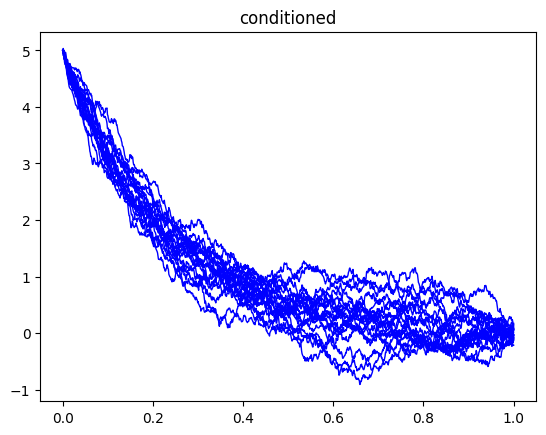

In [5]:
cond_keys = jax.random.split(key, num_trajectories)

drift, diffusion = sde_ornstein_uhlenbeck.vector_fields()
time_grid = jnp.linspace(t_start, T, N)

cond = jax.vmap(sde_utils.conditioned, (0, None, None, None, None, None))(traj_keys, time_grid, x0, score, drift, diffusion)

linewidth=1.
alpha=1.

# time_partial = jnp.append(time_grid[::10], T)
# y_end = jnp.ones((num_trajectories, 1, 1)) * jnp.asarray(y)
# cond_partial = jnp.append(cond[:, ::10], y_end, axis=1)
time_partial = time_grid
cond_partial = cond

for traj in cond_partial:
    plt.plot(time_partial, traj, linewidth=linewidth, alpha=alpha, color="blue")
plt.title("conditioned")
plt.show()